The sGA best solution is: ((4, 5), [0, 0, 0, 0, 0])
The cGA best solution is: ((5, 4), [1, 1, 1, 1, 1])


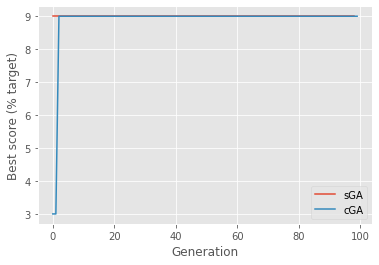

In [18]:
################################################################################
## Imports

from random import random
from pyeasyga import pyeasyga
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

################################################################################
## Common code

# Data
data = [0] * 5

# Define fitness function A (ftrap5)
def ff_a(individual, data=None):
  u = sum(individual)
  if u < 5:
    return 4 - u
  return 5

# Define fitness function B (invftrap5)
def ff_b(individual, data=None):
  u = sum(individual)
  if u > 0:
    return u - 1
  return 5

# Define the main fitness function
def fitness_function(individual, data=None):
  return (ff_a(individual, data), ff_b(individual, data))

# Sort function: fast non-dominated sort
def nsgaii(population):
  # Initialize the sorted population
  front = [[]]
  # Initialize the set of solutions that are dominated
  s = [[] for i in range(len(population))]
  # Initialize the number of solutions which dominate an individual
  n = [0 for i in range(len(population))]
  # Initialize the rank of solutions
  rank = [0 for i in range(len(population))]
  # Looks for the `p`-dominated solutions and calculates the degree of domination over `p`
  for p in range(len(population)):
    s[p] = []
    n[p] = 0
    # Get `p` fitness
    pfa, pfb = population[p].fitness
    for q in range(len(population)):
      # Get `q` fitness
      qfa, qfb = population[q].fitness
      # Check which dominates which
      if (pfa > qfa and pfb > qfb) or (pfa >= qfa and pfb > qfb) or (pfa > qfa and pfb >= qfb):
        s[p].append(q)
      elif (qfa > pfa and qfb > pfb) or (qfa >= pfa and qfb > pfb) or (qfa > pfa and qfb >= pfb):
        n[p] += 1
    # Check if `p` belongs to the fisrt front
    if n[p] == 0:
      rank[p] = 0
      if p not in front[0]:
        front[0].append(p)
  # Initiliaze the front counter
  i = 0
  while front[i] != []:
    aux = []
    for p in front[i]:
      for q in s[p]:
        n[q] = n[q] - 1
        if n[q] == 0:
          rank[q] = i + 1
          if q not in aux:
            aux.append(q)
    i += 1
    front.append(aux)
  # Remove the last set of individuals
  del front[len(front) - 1]
  # Convert to a usual population list
  sorted_pop = []
  for f in front:
    for i in f:
      sorted_pop.append(population[i])
  return sorted_pop

################################################################################
## Simple Genetic Algorithm (sGA)

# Best score progress
progress_sga = []

# Initialize genetic algorithm
sga = pyeasyga.GeneticAlgorithm(data)

# Set fitness function
sga.fitness_function = fitness_function

def rank_population(self):
  self.current_generation = nsgaii(self.current_generation)
sga.rank_population = rank_population

def create_first_generation(self):
  self.create_initial_population()
  self.calculate_population_fitness()
  self.rank_population(self)
sga.create_first_generation = create_first_generation

def create_next_generation(self):
  self.create_new_population()
  self.calculate_population_fitness()
  self.rank_population(self)
sga.create_next_generation = create_next_generation

# Set evolution function
def run(self):
  self.create_first_generation(self)
  for _ in range(1, self.generations):
    self.rank_population(self)
    self.create_next_generation(self)
    fitness, _ = sga.best_individual()
    fa, fb = fitness
    progress_sga.append((fa + fb))
sga.run = run

# Run sGA
sga.run(sga)
# Get best individual
result = sga.best_individual()
# Print result
print('The sGA best solution is: {}'.format(result))

################################################################################
## Compact Genetic Algorithm (cGA)

# Best score progress
progress_cga = []

# Initialize genetic algorithm
cga = pyeasyga.GeneticAlgorithm(data)

# Update probability vector
def update_prob(winner, loser, prob, popsize):
  for i in range(0, len(prob)):
    if winner[i] != loser[i]:
      if winner[i] == 1:
        prob[i] += 1.0 / float(popsize)
      else:
        prob[i] -= 1.0 / float(popsize)

# Create a new individual
def create_individual(prob):
  individual = []
  for p in prob:
    if random() < p:
      individual.append(1)
    else:
      individual.append(0)
  return pyeasyga.Chromosome(individual)
cga.create_individual = create_individual

# Make competition between two individuals
def compete(a, b):
  pfa, pfb = a.fitness
  qfa, qfb = b.fitness
  if (pfa > qfa and pfb > qfb) or (pfa >= qfa and pfb > qfb) or (pfa > qfa and pfb >= qfb):
    return a, b
  else:
    return b, a

# Set fitness function
cga.fitness_function = fitness_function

# Set evolution function
def run(self):
  # Initialize probability vector
  prob = [0.5] * len(self.seed_data)
  # Initialize best solution
  best = None
  # Run `i` generations
  for _ in range(0, self.generations):
    # Create individuals
    a = self.create_individual(prob)
    b = self.create_individual(prob)
    # Calculate fitness for each individual
    a.fitness = self.fitness_function(a.genes)
    b.fitness = self.fitness_function(b.genes)
    # Get the best and worst individual
    winner, loser = compete(a, b)
    # Update best solution
    if best:
      if winner.fitness > best.fitness:
        best = winner
    else:
      best = winner
    # Update the probability vector based on the success of each bit
    update_prob(winner.genes, loser.genes, prob, self.population_size)
    fa, fb = best.fitness
    progress_cga.append((fa + fb))
  # Add final solution
  self.current_generation.append(best)
cga.run = run

# Run evolution
cga.run(cga)
# Get best individual
result = cga.best_individual()
# Print result
print('The cGA best solution is: {}'.format(result))

################################################################################
## Plot comparison chart

line_sga, = plt.plot(progress_sga, label='sGA')
line_cga, = plt.plot(progress_cga, label='cGA')
plt.legend([line_sga, line_cga], ['sGA', 'cGA'])
plt.xlabel('Generation')
plt.ylabel('Best score (% target)')
plt.show()

################################################################################